In [17]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
import matplotlib.pyplot as plt
import numpy as np
import pathlib
from keras.utils.vis_utils import plot_model

In [20]:
img_height = 224
img_width = 224
input_shape = (img_width, img_height, 3)
batch_size = 32
train_dir = pathlib.Path('D:/Thesis_data/structure_dataset/training_img')
test_dir  = pathlib.Path('D:/Thesis_data/structure_dataset/testing_img')
checkpoint_dir = pathlib.Path('D:/TF_checkpoint/compartmentized')
model_dir = pathlib.Path('D:/TF_backup/compartment/cpm-untrained.h5')
model_plot_dir = pathlib.Path('D:/TF_backup/compartment/cpm.png')
classes = ["Compartmentize", "Plated", "Others"]

In [11]:
train_ds = keras.utils.image_dataset_from_directory(
    train_dir,
    labels="inferred",
    label_mode="categorical",
    seed=665,
    shuffle=True,
    validation_split=0.1,
    subset="training",
    image_size=(img_height, img_width),
    batch_size=batch_size
)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

model_checkpoint = keras.callbacks.ModelCheckpoint(
    checkpoint_dir,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
)

Found 13440 files belonging to 3 classes.
Using 12096 files for training.


In [12]:
# for img,lab in train_ds.take(1):
#     print(np.shape(img))

In [21]:
input_layer = layers.Input(shape=input_shape)
bri = tf.image.adjust_brightness(input_layer, 15)
hsv = tf.image.rgb_to_hsv(input_layer)

edge = tf.image.sobel_edges(bri)
thres = layers.ThresholdedReLU(theta=40)(edge)
split1, split2 = tf.split(value=thres, num_or_size_splits=[1,1], axis=4)
output1 = tf.squeeze(split1, axis=4)
output2 = tf.squeeze(split2, axis=4)

# Block1
conv1rgb = layers.Conv2D(25, kernel_size=(7,7), activation="relu")(output1)
pool1rgb = layers.MaxPooling2D(pool_size=(2,2), strides=2)(conv1rgb)
conv15rgb = layers.Conv2D(25, kernel_size=(7,7), activation="relu")(output2)
pool15rgb = layers.MaxPooling2D(pool_size=(2,2), strides=2)(conv15rgb)
add = layers.Add()([pool1rgb, pool15rgb])
conv2rgb = layers.Conv2D(50, kernel_size=(25,25), activation="relu")(add)
pool2rgb = layers.MaxPooling2D(pool_size=(2,2), strides=2)(conv2rgb)
conv3rgb = layers.Conv2D(28, kernel_size=(9,9), activation="relu")(pool2rgb)
pool3rgb = layers.MaxPooling2D(pool_size=(2,2), strides=2)(conv3rgb)

#Block2
conv1hsv = layers.Conv2D(25, kernel_size=(7,7), activation="relu")(hsv)
pool1hsv = layers.MaxPooling2D(pool_size=(2,2), strides=2)(conv1rgb)
conv2hsv = layers.Conv2D(50, kernel_size=(25,25), activation="relu")(pool1hsv)
pool2hsv = layers.MaxPooling2D(pool_size=(2,2), strides=2)(conv2hsv)
conv3hsv = layers.Conv2D(28, kernel_size=(9,9), activation="relu")(pool2hsv)
pool3hsv = layers.MaxPooling2D(pool_size=(2,2), strides=2)(conv3hsv)

# concat

conc = layers.Concatenate(axis=1)([pool3rgb, pool3hsv])

#Classification Block
flat = layers.Flatten()(conc)
drop = layers.Dropout(0.5)(flat)
dense3 = layers.Dense(512, activation="relu")(drop)
drop2 = layers.Dropout(0.4)(dense3)
dense4 = layers.Dense(64, activation="relu")(drop2)
drop3 = layers.Dropout(0.2)(dense4)
output_layer = layers.Dense(3, activation="softmax")(drop3)

model = keras.Model(input_layer, output_layer)

model.summary()
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

model.save(model_dir)

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 tf.image.adjust_brightness_5 (  (None, 224, 224, 3)  0          ['input_6[0][0]']                
 TFOpLambda)                                                                                      
                                                                                                  
 tf.compat.v1.shape_5 (TFOpLamb  (4,)                0           ['tf.image.adjust_brightness_5[0]
 da)                                                             [0]']                      

In [ ]:
plot_model(model, to_file=model_plot_dir, show_shapes=True)


In [19]:
epochs = 8
model.fit(train_ds, epochs=epochs, callbacks=[model_checkpoint])
model.save(model_dir)

Epoch 1/8
378/378 [==============================] - 213s 564ms/step - loss: 0.9256 - accuracy: 0.5190
Epoch 2/8
153/378 [===========>..................] - ETA: 2:06 - loss: 0.8754 - accuracy: 0.5494

In [16]:
## Test model
test_ds = keras.utils.image_dataset_from_directory(
    test_dir,
    label_mode="categorical",
    shuffle=True,
    image_size=(img_height, img_width),
    batch_size=batch_size
)
test_ds = test_ds.prefetch(tf.data.AUTOTUNE)

score = model.evaluate(test_ds, verbose=1)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Found 3360 files belonging to 3 classes.
105/105 [==============================] - 18s 163ms/step - loss: 0.9037 - accuracy: 0.5586
Test loss: 0.903677225112915
Test accuracy: 0.5586309432983398


[0.31382492 0.2979787  0.38819635] [0. 1. 0.]
[0.37179175 0.18610765 0.4421006 ] [1. 0. 0.]
[0.45840144 0.12318689 0.41841164] [0. 0. 1.]
[0.14803603 0.640399   0.21156497] [0. 1. 0.]
[0.3475369  0.31035355 0.3421095 ] [0. 0. 1.]
[0.38515806 0.11187696 0.502965  ] [0. 0. 1.]
[0.37547076 0.27048102 0.35404822] [0. 1. 0.]
[0.26102933 0.42357627 0.31539443] [0. 1. 0.]
[0.19256198 0.5910556  0.21638249] [0. 0. 1.]
[0.4340719  0.2564745  0.30945355] [1. 0. 0.]
[0.30789933 0.35913613 0.3329645 ] [0. 1. 0.]
[0.31479886 0.34841853 0.33678263] [0. 0. 1.]
[0.41703817 0.14384024 0.43912157] [1. 0. 0.]
[0.42444164 0.15101333 0.42454505] [0. 0. 1.]
[2.9036510e-04 9.9953616e-01 1.7348879e-04] [0. 1. 0.]
[0.4376652  0.23935978 0.322975  ] [1. 0. 0.]
[0.43108997 0.12410748 0.44480255] [0. 0. 1.]
[0.11332003 0.7486703  0.13800965] [0. 1. 0.]
[1.7293047e-06 9.9999487e-01 3.3521112e-06] [0. 1. 0.]
[0.22462638 0.3991123  0.3762613 ] [0. 0. 1.]
[0.36823592 0.25327086 0.37849325] [1. 0. 0.]
[4.9640774e-04 9

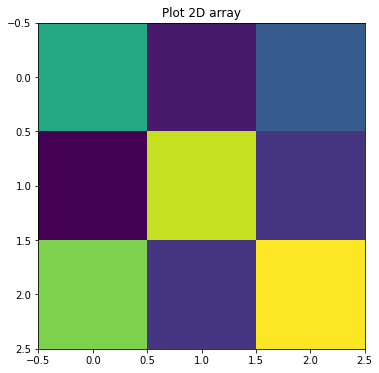

In [18]:
# draw confusion matrix
i = 0
cmatrix = np.zeros((3,3), dtype=np.int16)
for img,lab in test_ds.take(20):
    result = model.predict(img, use_multiprocessing=True)
    for j in range(np.size(result,axis=0)):
        id1 = np.argmax(result[j])
        id2 = np.argmax(lab[j])
        print(result[j], lab[j].numpy())
        cmatrix[id1][id2] = cmatrix[id1][id2] + 1
cmatrix = np.absolute(cmatrix)
print(repr(cmatrix))

fig = plt.figure(figsize=(6,6))
plt.imshow(cmatrix)
plt.title("Plot 2D array")
plt.show()